In [11]:
# import the necessary packages
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2
 

In [14]:
!wget https://assets.catawiki.nl/assets/2019/2/15/3/c/e/3cefac6a-855e-4cd2-b332-7cfd27846a11.jpg -O gameboy.jpg

--2019-08-11 16:04:52--  https://assets.catawiki.nl/assets/2019/2/15/3/c/e/3cefac6a-855e-4cd2-b332-7cfd27846a11.jpg
正在解析主机 assets.catawiki.nl (assets.catawiki.nl)... 184.85.117.136
正在连接 assets.catawiki.nl (assets.catawiki.nl)|184.85.117.136|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：50140 (49K) [image/jpeg]
正在保存至: “gameboy.jpg”

gameboy.jpg         100%[===================>]  48.96K  --.-KB/s  用时 0.1s      

2019-08-11 16:04:53 (327 KB/s) - 已保存 “gameboy.jpg” [50140/50140])



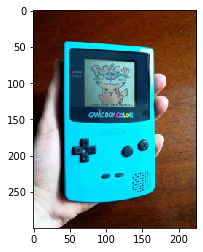

In [18]:
# load the query image, compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread('gameboy.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ratio = image.shape[0] / 300.0
orig = image.copy()
image = imutils.resize(image, height = 300)
plt.imshow(image)

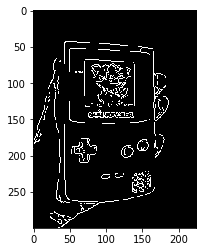

In [24]:
# convert the image to grayscale, blur it, and find edges in the image
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
filterd = cv2.bilateralFilter(gray, 11, 17, 17)
edged = cv2.Canny(filterd, 30, 200)
plt.imshow(edged)

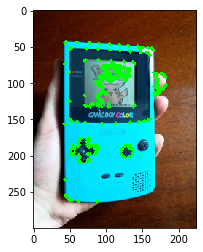

In [25]:
# find contours in the edged image, keep only the largest
# ones, and initialize our screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]

cpyImg = image.copy()
for c in cnts:
    cv2.drawContours(cpyImg, c, -1, (0, 255, 0), 3)
    plt.imshow(cpyImg)


In [26]:
# screenCnt = None

# # loop over our contours
# for c in cnts:
#     # approximate the contour
#     peri = cv2.arcLength(c, True)
#     approx = cv2.approxPolyDP(c, 0.09 * peri, True)
 
#     # if our approximated contour has four points, then
#     # we can assume that we have found our screen
#     if len(approx) == 4:
#         screenCnt = approx
#         break

# print(screenCnt)

import ipywidgets.widgets as widgets
import traitlets
from traitlets.config.configurable import Configurable

# create two sliders with range [-1.0, 1.0]
slider = widgets.FloatSlider(description='left', min=0, max=1, step=0.001, orientation='horizontal', readout_format='.3f',)
screenCnt = None
  
def draw_contours(slider):
    cnt = None
    # loop over our contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        # epsilon Parameter specifying the approximation accuracy. This is the maximum distance between the original curve and its approximation.
        # 2nd参数是epsilon， 判断点到相对应的line segment 的距离的阈值。（距离大于此阈值则舍弃，小于此阈值则保留，epsilon越小，折线的形状越“接近”曲线。）
        approx = cv2.approxPolyDP(c, float(slider)*peri, True)
        if len(approx) == 4:
            cnt = approx
            break

    cloned_image = image.copy()
    if cnt is not None:
        screenCnt = cnt
        cv2.drawContours(cloned_image, [cnt], -1, (0, 255, 0), 3)
    plt.imshow(cloned_image)

        
output = widgets.interactive_output(draw_contours, {'slider': slider})

        
# create a horizontal box container to place the sliders next to eachother
slider_container = widgets.VBox([slider, output])

# display the container in this cell's output
display(slider_container)

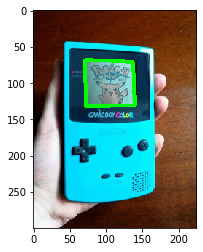

In [27]:
screenCnt = None

# loop over our contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    # epsilon Parameter specifying the approximation accuracy. This is the maximum distance between the original curve and its approximation.
    # 2nd参数是epsilon， 判断点到相对应的line segment 的距离的阈值。（距离大于此阈值则舍弃，小于此阈值则保留，epsilon越小，折线的形状越“接近”曲线。）
    approx = cv2.approxPolyDP(c, 0.162*peri, True)
    if len(approx) == 4:
        screenCnt = approx
        break

cloned_image = image.copy()
if screenCnt is not None:
    cv2.drawContours(cloned_image, [screenCnt], -1, (0, 255, 0), 3)
plt.imshow(cloned_image)
    
# now that we have our screen contour, we need to determine
# the top-left, top-right, bottom-right, and bottom-left
# points so that we can later warp the image -- we'll start
# by reshaping our contour to be our finals and initializing
# our output rectangle in top-left, top-right, bottom-right,
# and bottom-left order
pts = screenCnt.reshape(4, 2)
rect = np.zeros((4, 2), dtype = "float32")
 
# the top-left point has the smallest sum whereas the
# bottom-right has the largest sum
s = pts.sum(axis = 1)
rect[0] = pts[np.argmin(s)]
rect[2] = pts[np.argmax(s)]
 
# compute the difference between the points -- the top-right
# will have the minumum difference and the bottom-left will
# have the maximum difference
diff = np.diff(pts, axis = 1)
rect[1] = pts[np.argmin(diff)]
rect[3] = pts[np.argmax(diff)]
 
# multiply the rectangle by the original ratio
rect *= ratio

In [28]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [30]:

# now that we have our rectangle of points, let's compute
# the width of our new image
(tl, tr, br, bl) = rect
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
 
# ...and now for the height of our new image
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
 
# take the maximum of the width and height values to reach
# our final dimensions
maxWidth = max(int(widthA), int(widthB))
maxHeight = max(int(heightA), int(heightB))
 
# construct our destination points which will be used to
# map the screen to a top-down, "birds eye" view
dst = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]], dtype = "float32")
 
# calculate the perspective transform matrix and warp
# the perspective to grab the screen
M = cv2.getPerspectiveTransform(rect, dst)
warp = cv2.warpPerspective(orig, M, (maxWidth, maxHeight))

# convert the warped image to grayscale and then adjust
# the intensity of the pixels to have minimum and maximum
# values of 0 and 255, respectively
warp = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)
warp = exposure.rescale_intensity(warp, out_range = (0, 255))
 
# the pokemon we want to identify will be in the top-right
# corner of the warped image -- let's crop this region out
(h, w) = warp.shape
(dX, dY) = (int(w * 0.4), int(h * 0.45))
crop = warp[3:dY-6, w - dX+4:w - 5]

show_images([warp,crop])

ValueError: too many values to unpack (expected 2)